**Problem 1** (10 pts): Implement and compare different Autoencoder architectures for detecting fraudulent transactions (anomalies) in the Kaggle Credit Card Fraud Detection Dataset. You can drop the ‘time’ feature. Use only non-fraud (label = 0) for training; both fraud and non-fraud for testing. Minimum number of training epochs is 50. You can implement early stopping (callbacks) criteria.

Implement the following Autoencoder variants:
* Vanilla Autoencoder: 1 hidden layer (encoder + decoder).
*Deep Autoencoder: Minimum 3 layers in encoder and 3 in decoder. Use ReLU activations and dropout.
* Sparse Autoencoder: Same architecture as Deep AE. Add L1 regularization to enforce sparsity.
* Denoising Autoencoder: Add Gaussian noise to input during training.

Plot distribution of reconstruction error of the test data. Use a threshold on reconstruction error on the test set and report Precision, Recall, and F1-Score.


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


In [2]:
# Loading dataset
df = pd.read_csv('creditcard.csv')

In [3]:
#printing the first 5 rows of the dataset
display(df.head(5))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape


(284807, 31)

In [5]:
df.isnull().values.any()

np.False_

<ipython-input-6-2c8fd8adbd4f>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


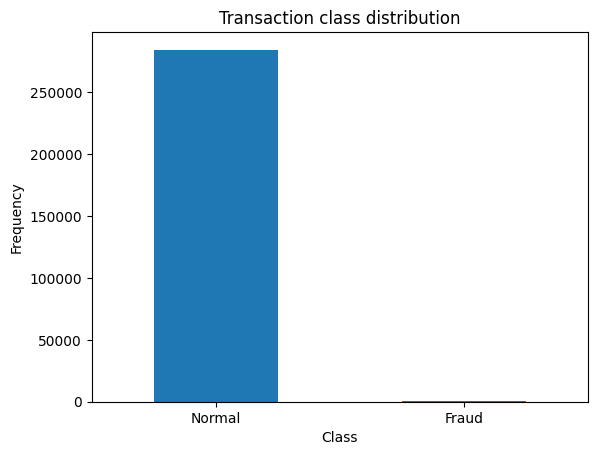

In [6]:
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [7]:
print("Normal transactions:", df[df['Class'] == 0].shape[0])
print("Fraudulent transactions:", df[df['Class'] == 1].shape[0])


Normal transactions: 284315
Fraudulent transactions: 492


Here we can see that the ratio of fraudulent to normal transactions is very large, confirming that this is a highly imbalanced dataset, which is very important for anomaly detection.

In [8]:
# removing 'Time' column as mentioned and normalizing
df.drop(columns=['Time'], inplace=True)

X = df.drop('Class', axis=1)
y = df['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# using non-fraud data only for training and all data for testing
X_train = X_scaled[y == 0]
X_test = X_scaled
y_test = y


In [9]:
#evaluation function

def evaluate_threshold(errors, labels, threshold):
    predictions = (errors > threshold).astype(int)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return precision, recall, f1


## Vanilla Autoencoder

In [10]:
input_dim = X_train.shape[1]
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

# Build & Compile Model
vanilla_ae = Model(input_layer, decoded)
vanilla_ae.compile(optimizer='adam', loss='mse')

#train
vanilla_ae.fit(X_train, X_train, epochs=100, batch_size=128,
               validation_split=0.2, callbacks=[early_stop], verbose=1)

recon_vanilla = vanilla_ae.predict(X_test)
error_vanilla = np.mean(np.square(X_test - recon_vanilla), axis=1)


Epoch 1/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.4581 - val_loss: 0.0145
Epoch 2/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0093 - val_loss: 0.0024
Epoch 3/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0015 - val_loss: 4.6011e-04
Epoch 4/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.6648e-04 - val_loss: 2.1013e-04
Epoch 5/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.5125e-04 - val_loss: 7.5506e-04
Epoch 6/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.6155e-04 - val_loss: 4.5076e-04
Epoch 7/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.9304e-04 - val_loss: 1.6625e-04
Epoch 8/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.0576e-04 - val_loss: 1.0515e-04
Epoch 9/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.6577e-04 - val_loss: 1.2453e-04
Epoch 10/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.5519e-04 - val_loss: 3.3395e-04
Epoch 11/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2m

In [11]:
#summary
vanilla_ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │           957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,753 (22.48 KB)

 Trainable params: 1,917 (7.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,836 (14.99 KB)

## Deep Autoencoder

In [12]:
input_layer = Input(shape=(input_dim,))

# 4-Layer ENCODER
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
encoded = Dense(16, activation='relu')(x)

# 4-Layer DECODER
x = Dense(32, activation='relu')(encoded)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
decoded = Dense(input_dim, activation='linear')(x)

# Build & Compile Model
deep_ae = Model(input_layer, decoded)
deep_ae.compile(optimizer='adam', loss='mse')

# Train
deep_ae.fit(X_train, X_train, epochs=100, batch_size=128,
            validation_split=0.2, callbacks=[early_stop], verbose=1)

recon_deep = deep_ae.predict(X_test)
error_deep = np.mean(np.square(X_test - recon_deep), axis=1)


Epoch 1/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.7995 - val_loss: 0.5401
Epoch 2/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6112 - val_loss: 0.5059
Epoch 3/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5666 - val_loss: 0.4709
Epoch 4/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5481 - val_loss: 0.4584
Epoch 5/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5260 - val_loss: 0.4460
Epoch 6/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5108 - val_loss: 0.4359
Epoch 7/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5058 - val_loss: 0.4251
Epoch 8/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5025 - val_loss: 0.4056
Epoch 9/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4968 - val_loss: 0.4087
Epoch 10/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4993 - val_loss: 0.4081
Epoch 11/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4903 - val_loss: 0.4076
Epoch 12/100
1777/

In [13]:
#summary
deep_ae.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,265 (344.79 KB)

 Trainable params: 29,421 (114.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,844 (229.86 KB)

## Sparse Autoencoder

In [14]:
input_layer = Input(shape=(input_dim,))

# 4-Layer ENCODER with L1 regularization at bottleneck
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
encoded = Dense(16, activation='relu',
                activity_regularizer=regularizers.l1(1e-5))(x)

# 4-Layer DECODER
x = Dense(32, activation='relu')(encoded)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
decoded = Dense(input_dim, activation='linear')(x)

# Build & Compile Model
sparse_ae = Model(input_layer, decoded)
sparse_ae.compile(optimizer='adam', loss='mse')

# Train
sparse_ae.fit(X_train, X_train, epochs=100, batch_size=128,
              validation_split=0.2, callbacks=[early_stop], verbose=1)

recon_sparse = sparse_ae.predict(X_test)
error_sparse = np.mean(np.square(X_test - recon_sparse), axis=1)



Epoch 1/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.8035 - val_loss: 0.5757
Epoch 2/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6071 - val_loss: 0.5032
Epoch 3/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5693 - val_loss: 0.5129
Epoch 4/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5514 - val_loss: 0.4874
Epoch 5/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5418 - val_loss: 0.4557
Epoch 6/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5331 - val_loss: 0.4469
Epoch 7/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5131 - val_loss: 0.4369
Epoch 8/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5015 - val_loss: 0.4419
Epoch 9/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5043 - val_loss: 0.4220
Epoch 10/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4980 - val_loss: 0.4235
Epoch 11/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4974 - val_loss: 0.4126
Epoch 12/100
1777/

In [15]:
#summary
sparse_ae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,265 (344.79 KB)

 Trainable params: 29,421 (114.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,844 (229.86 KB)

## Denoising Autoencoder

In [16]:
input_layer = Input(shape=(input_dim,))
noisy = GaussianNoise(0.2)(input_layer)
x = Dense(64, activation='relu')(noisy)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
encoded = Dense(16, activation='relu')(x)

x = Dense(32, activation='relu')(encoded)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
decoded = Dense(input_dim, activation='linear')(x)

# Build & Compile Model
denoise_ae = Model(input_layer, decoded)
denoise_ae.compile(optimizer='adam', loss='mse')

#train
denoise_ae.fit(X_train, X_train, epochs=100, batch_size=128,
               validation_split=0.2, callbacks=[early_stop], verbose=1)

recon_denoise = denoise_ae.predict(X_test)
error_denoise = np.mean(np.square(X_test - recon_denoise), axis=1)


Epoch 1/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.8323 - val_loss: 0.5377
Epoch 2/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6160 - val_loss: 0.4703
Epoch 3/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5603 - val_loss: 0.4267
Epoch 4/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5306 - val_loss: 0.4105
Epoch 5/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5183 - val_loss: 0.4081
Epoch 6/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5058 - val_loss: 0.3879
Epoch 7/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5053 - val_loss: 0.3899
Epoch 8/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4941 - val_loss: 0.3739
Epoch 9/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4945 - val_loss: 0.3687
Epoch 10/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4862 - val_loss: 0.3747
Epoch 11/100
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4796 - val_loss: 0.3908
Epoch 12/100
1777/

In [17]:
#summary
denoise_ae.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,209 (106.29 KB)

 Trainable params: 9,069 (35.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,140 (70.86 KB)

## Plots

In [18]:
# Calculate reconstruction errors for different models (assuming you have reconstructions)
errors_vanilla = np.mean(np.square(X_test - recon_vanilla), axis=1)
errors_deep = np.mean(np.square(X_test - recon_deep), axis=1)
errors_sparse = np.mean(np.square(X_test - recon_sparse), axis=1)
errors_denoise = np.mean(np.square(X_test - recon_denoise), axis=1)

# Store the errors in a dictionary
model_errors = {
    'Vanilla Autoencoder': errors_vanilla,
    'Deep Autoencoder': errors_deep,
    'Sparse Autoencoder': errors_sparse,
    'Denoising Autoencoder': errors_denoise
}


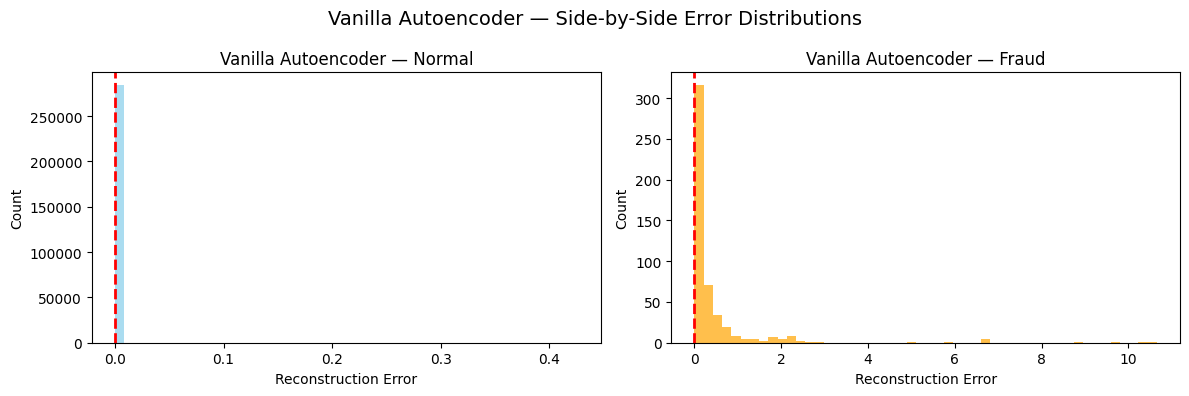

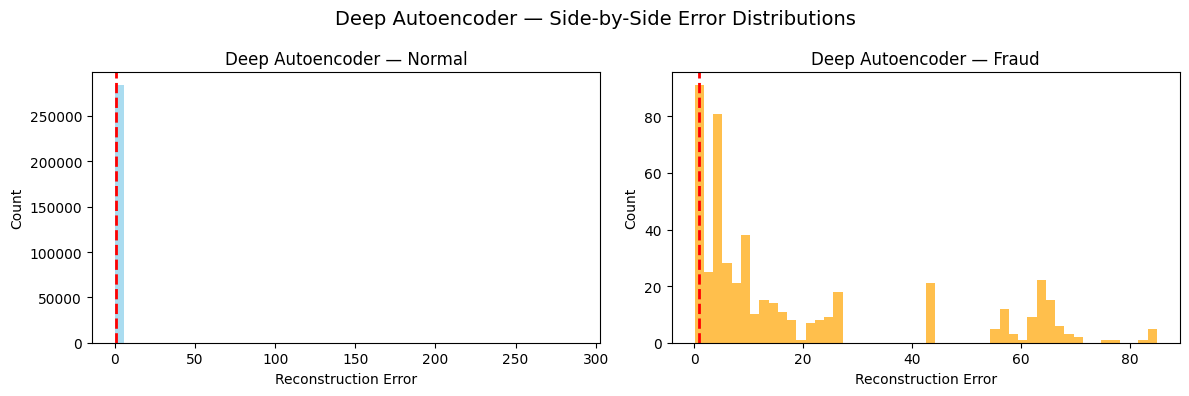

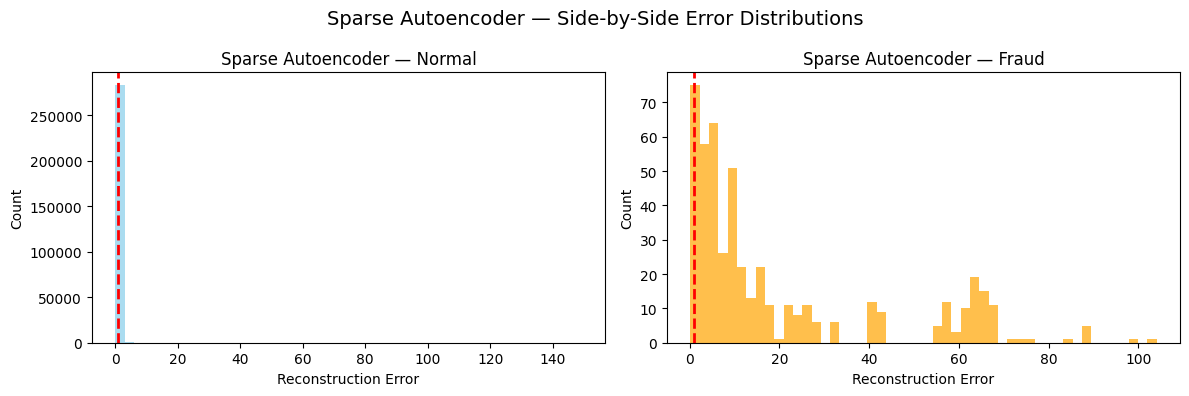

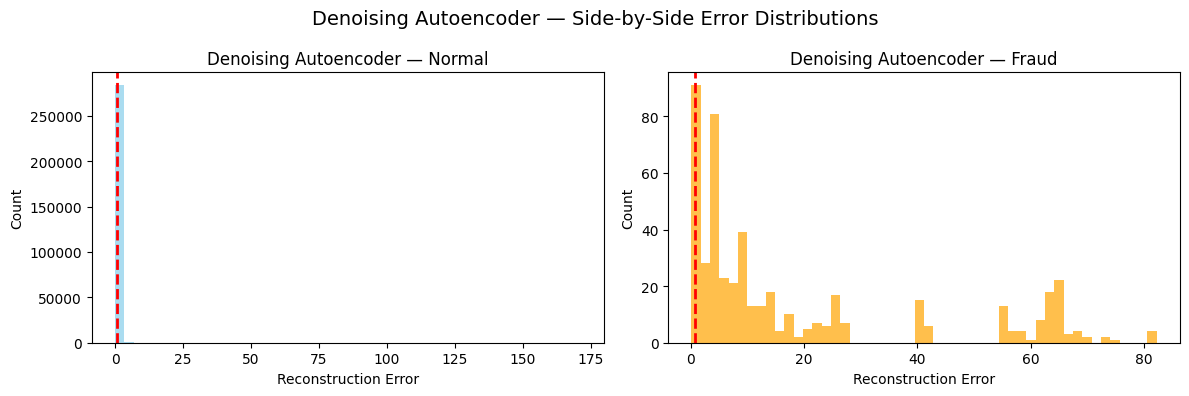

In [19]:
for name, errors in model_errors.items():
    threshold = np.percentile(errors, 95)

    plt.figure(figsize=(12, 4))

    # Plot for Normal transactions
    plt.subplot(1, 2, 1)
    plt.hist(errors[y_test == 0], bins=50, color='skyblue', alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', linewidth=2)
    plt.title(f"{name} — Normal")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Count")

    # Plot for Fraud transactions
    plt.subplot(1, 2, 2)
    plt.hist(errors[y_test == 1], bins=50, color='orange', alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', linewidth=2)
    plt.title(f"{name} — Fraud")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Count")

    plt.suptitle(f"{name} — Side-by-Side Error Distributions", fontsize=14)
    plt.tight_layout()
    plt.show()


In [20]:
print("Final Evaluation (95th Percentile Thresholds for Each Model):\n")

models = {
    "Vanilla AE": error_vanilla,
    "Deep AE": error_deep,
    "Sparse AE": error_sparse,
    "Denoising AE": error_denoise
}

for name, errors in models.items():
    threshold = np.percentile(errors, 95)
    preds = (errors > threshold).astype(int)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    detected = np.sum((preds == 1) & (y_test == 1))
    total_frauds = np.sum(y_test == 1)

    #results
    print(f"{name} — Threshold: {threshold:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"Frauds correctly detected: {detected} / {total_frauds}")
    print("-" * 60)


Final Evaluation (95th Percentile Thresholds for Each Model):

Vanilla AE — Threshold: 0.0000
Precision: 0.0291, Recall: 0.8435, F1-Score: 0.0563
Frauds correctly detected: 415 / 492
------------------------------------------------------------
Deep AE — Threshold: 0.9072
Precision: 0.0297, Recall: 0.8598, F1-Score: 0.0574
Frauds correctly detected: 423 / 492
------------------------------------------------------------
Sparse AE — Threshold: 0.9964
Precision: 0.0307, Recall: 0.8882, F1-Score: 0.0593
Frauds correctly detected: 437 / 492
------------------------------------------------------------
Denoising AE — Threshold: 0.7767
Precision: 0.0297, Recall: 0.8598, F1-Score: 0.0574
Frauds correctly detected: 423 / 492
------------------------------------------------------------


## Interpretation:
- For all the four autoencoders the thresholds were set at the 95th percentile of reconstruction errors for a fair comparison.
- Sparse AE performed the best, each detecting 437 out of 492 frauds (88.82% recall), which was the highest among all models.
- Precision was low around 3% for all models which is expected due to class the very high imbalance of thee dataset.


## Hyperparameter used
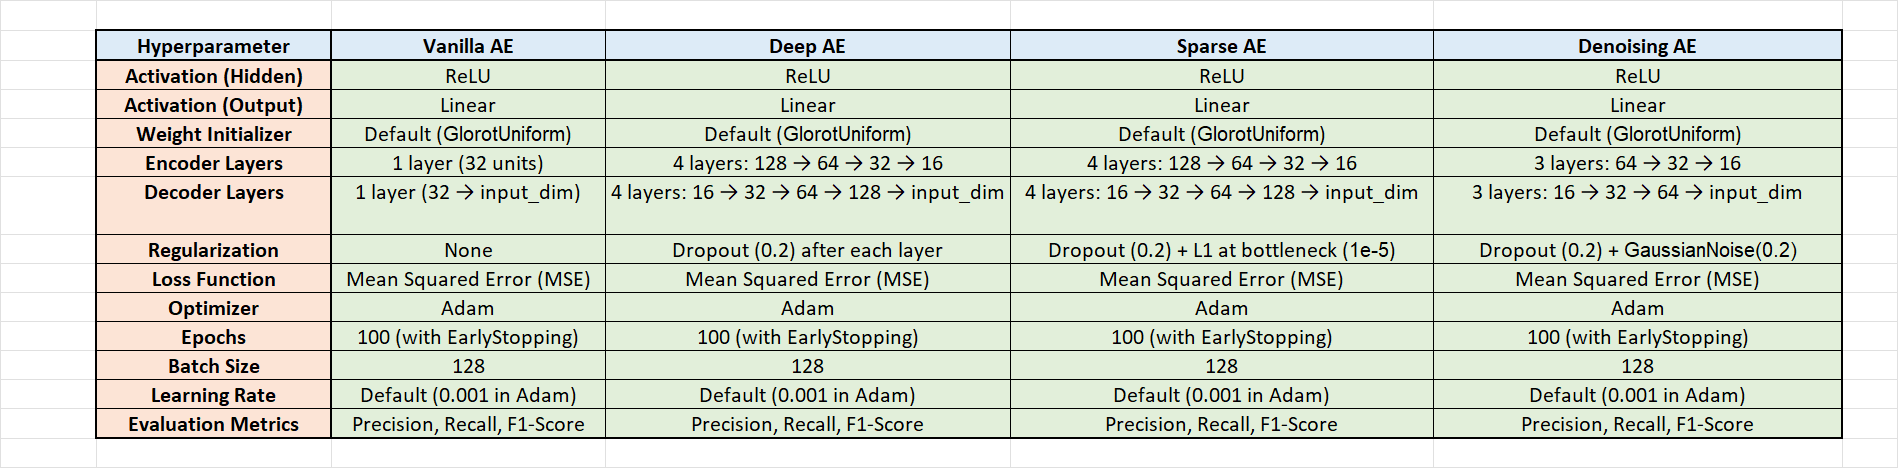


## Problem 2: Apply Variational Autoencoder on the Fashion MNIST Dataset. Number of epochs should be minimum of 100.

#### a) Use minimum of 4 convolutional layers in the encoder and 4 deconvolutional layers (Conv2DTranspose/ upscale) in the decoder.

In [21]:
# imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [22]:
 #Loading the fashion mnist  dataset

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [23]:
# Reshape to add channel dimension → (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


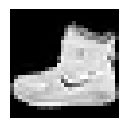

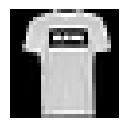

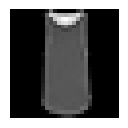

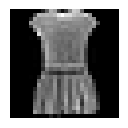

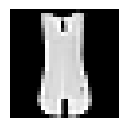

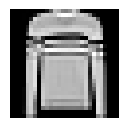

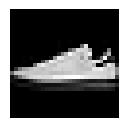

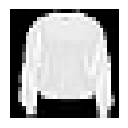

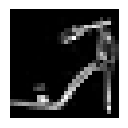

In [24]:
# Visualizing first 9 images
def show_image(image, cmap_type='gray'):
    plt.imshow(image.squeeze(), cmap=cmap_type)
    plt.axis('off')
    plt.show()

sample = x_train[:9]
for a, i in enumerate(sample):
    plt.subplot(3, 3, a + 1)
    show_image(i)



In [25]:
# Print dataset shapes
print('Training data shape : ', x_train.shape, y_train.shape)
print('Testing data shape  : ', x_test.shape, y_test.shape)



Training data shape :  (60000, 28, 28, 1) (60000,)
Testing data shape  :  (10000, 28, 28, 1) (10000,)


In [26]:
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [27]:
# Check class labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [28]:
# define the input shape
input_shape = (28, 28, 1)

# define latent space for Fashion MNIST
latent_dim = 2

**Encoder**

In [29]:
# encoder model
encoder_inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs) # 1st Conv layer
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)  # 2nd Conv layer
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)  # 3rd Conv layer

x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)  # 4th Conv layer

x = layers.Flatten()(x)
latent_space_mean = layers.Dense(latent_dim)(x)
latent_space_log_var = layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_inputs, [latent_space_mean, latent_space_log_var], name='encoder')
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 256) │    295,168 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 2)         │     25,090 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 2)         │     25,090 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 438,020 (1.67 MB)

 Trainable params: 438,020 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

i) The encoder model has a total of **438,020 parameters**, all of which are **trainable**.  
ii) The model consists of **6 layers**: 4 convolutional layers, 2 max pooling layers, and 2 dense layers.
iii) The input shape of the model is **(None, 28, 28, 1)**, and the output shapes of each layer are as follows:
- `conv2d`: (None, 28, 28, 32)  
- `max_pooling2d`: (None, 14, 14, 32)  
- `conv2d_1`: (None, 14, 14, 64)  
- `max_pooling2d_1`: (None, 7, 7, 64)  
- `conv2d_2`: (None, 7, 7, 128)  
- `conv2d_3`: (None, 7, 7, 256)  
- `flatten`: (None, 12544)  
- `dense`: (None, 2)  
- `dense_1`: (None, 2)  

iv) The encoder model takes an input tensor of shape **(None, 28, 28, 1)** and outputs two tensors, representing the **mean** and **log variance** of the latent space, respectively.  
v) The encoder model contains a total of **4 convolutional layers** with **32, 64, 128, and 256 filters**, respectively.  
vi) Each convolutional layer is followed by **ReLU activation**, and two of them are followed by **max pooling layers** to reduce the spatial dimensions of the output.  
vii) The output of the final convolutional layer is **flattened** and passed through two **dense layers**, each with **2 units**, to obtain the **mean** and **log variance** of the **2-dimensional latent space**.


**Decoder**

In [30]:
# Defining the decoder model

decoder_inputs = keras.Input(shape=(latent_dim,))  # latent_dim = 2
x = layers.Dense(7 * 7 * 128, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 128))(x)

x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)

x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)

x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)  # 1 channel for grayscale

decoder = keras.Model(decoder_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 6272)           │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 256)      │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 701,569 (2.68 MB)

 Trainable params: 701,569 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

i) The decoder model has a total of **701,569 trainable parameters**.  
ii) It consists of **Dense layer**, a **Reshape layer**, **4 Conv2DTranspose layers**, **2 UpSampling2D layers**, and produces output of shape (28, 28, 1) to match the original grayscale image size.
iii) The summary of the decoder model is as follows:
- **InputLayer**: Accepts a 2D latent vector of shape **(None, 2)**.
- **Dense**: A fully connected layer with **6272 neurons** and ReLU activation, reshaping the latent vector into a tensor of shape **(7, 7, 128)**.
- **Reshape**: Reshapes the 1D vector output from the dense layer into a 4D tensor of shape **(None, 7, 7, 128)**.
- **Conv2DTranspose**: A transposed convolutional layer with **256 filters**, kernel size (3,3), padding 'same'. Output shape becomes **(None, 7, 7, 256)**.
- **UpSampling2D**: Doubles the spatial dimensions, changing the shape to **(None, 14, 14, 256)**.
- **Conv2DTranspose**: A transposed convolutional layer with **128 filters**, output shape becomes **(None, 14, 14, 128)**.
- **UpSampling2D**: Doubles the spatial dimensions again to **(None, 28, 28, 128)**.
- **Conv2DTranspose**: A transposed convolutional layer with **64 filters**, output shape **(None, 28, 28, 64)**.
- **Conv2DTranspose**: A transposed convolutional layer with **32 filters**, output shape **(None, 28, 28, 32)**.
- **Conv2DTranspose**: The final output layer with **1 filter** (grayscale), kernel size (3,3), sigmoid activation. The final output shape is (None, 28, 28, 1), matching the original input image size.
  
iv) Each Conv2DTranspose layer uses **ReLU activation** (except the last, which uses **sigmoid**) and applies **padding='same'** to preserve spatial dimensions. The decoder takes in the latent vector from the encoder and reconstructs the original Fashion MNIST image.


In [31]:
# Define the Variational Autoencoder (VAE) model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, kl_weight=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = tf.Variable(kl_weight, trainable=False)

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        reconstructed = self.decoder(z)

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(self.kl_weight * kl_loss)
        return reconstructed

In [32]:
# Build and compile model
vae = VAE(encoder, decoder, kl_weight=1.0)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

#train model with early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = vae.fit(
    x_train, x_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, x_test),
    callbacks=[early_stop]
)

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.9054e-05 - val_loss: 8.0606e-07
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.8656e-07 - val_loss: 2.6777e-08
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.7871e-08 - val_loss: 7.4208e-10
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 8.3149e-09 - val_loss: 5.3078e-09
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.6344e-09 - val_loss: -1.7607e-08
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.1931e-09 - val_loss: 4.8089e-08
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.1713e-09 - val_loss: 4.8280e-10
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.6362e-09 - val_loss: 5.6624e-10
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.9053e-09 - val_loss: 2.2650e-10
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.4722e-09 - val_loss: 3.4273e-10
Epoch 11/100
1875/1875 ━━━━

#### b) Display how the latent space clusters different classes of the training data.


In [33]:
z_mean, _ = encoder.predict(x_train, batch_size=128)

# latent space statistics
print("Latent space statistics:")
print("Min:", np.min(z_mean, axis=0))
print("Max:", np.max(z_mean, axis=0))
print("Standard Deviation:", np.std(z_mean, axis=0))



469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Latent space statistics:
Min: [-0.00018324 -0.00013597]
Max: [1.2377936e-04 9.4859293e-05]
Standard Deviation: [7.2577686e-06 6.9014663e-06]


In [34]:
# Normalizing
z_scaled = (z_mean - np.mean(z_mean, axis=0)) / (np.std(z_mean, axis=0) + 1e-8)



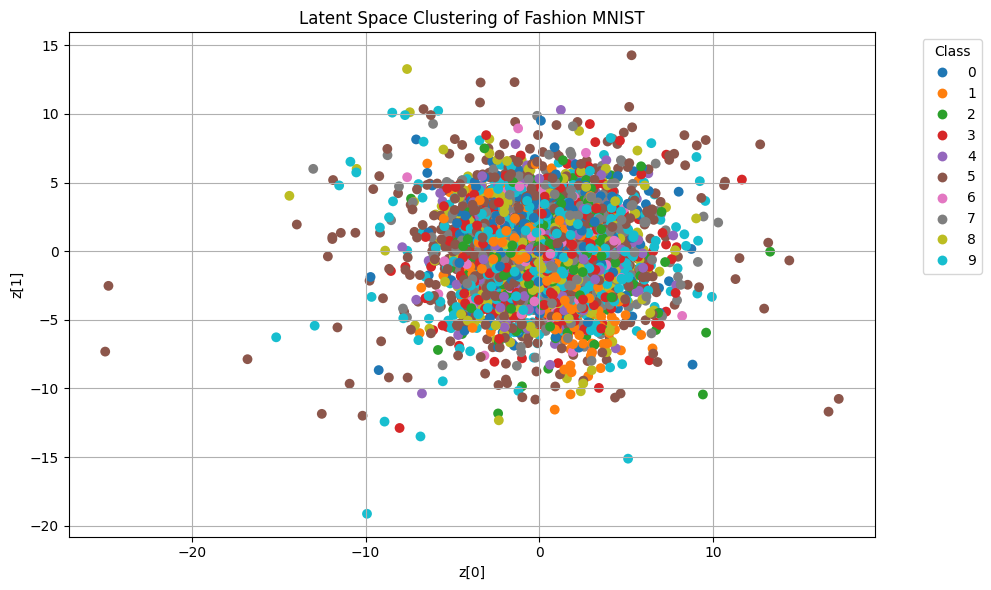

In [35]:
# Plot the latent space
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=z_scaled[:, 0],
    y=z_scaled[:, 1],
    hue=y_train,
    palette='tab10',
    s=50,
    edgecolor='none',
    legend='full'
)
plt.title("Latent Space Clustering of Fashion MNIST")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Results:
i) The latent space representation shows how the VAE has compressed the training images into a 2D latent space (z[0], z[1]).  
ii) Each point corresponds to an image, and its color represents the digit class label from 0 to 9.  

iii) The points are distributed across the center, with some overlap across classes. This suggests:
- The latent space is still compressed and not fully utilizing its available dimensions.
- KL divergence may still be dominating, causing the latent space to shrink and limiting class separation.

iv) The standard deviation values are very low, indicating that the latent vectors are tightly packed, which is expected due to KL regularization, but it also means that class separation is not well captured.


## Hyperparameter used


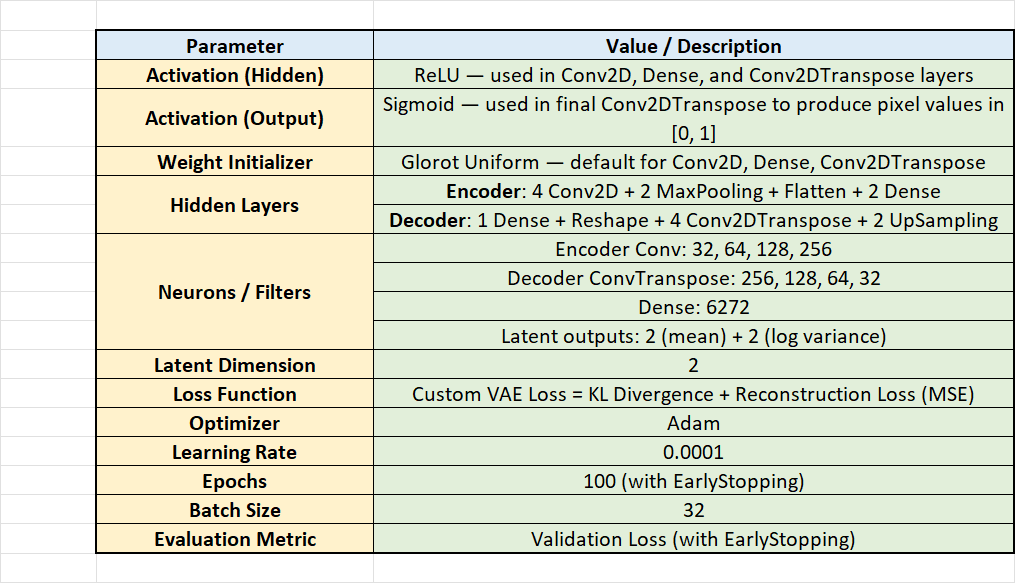